#  John Clauser, Michael Horne, Abner Shimony, and Richard Holt (CHSH) inequality

This notebook instantiates Quantum circuits with Qibo, in order to measure the violation of the CHSH inequality introduced in 1969:



We will show that in a quantum system the inequality is violated in the case of entangled particles with specific measurement angles.

In [2]:
from math import pi
import time
import numpy as np
import qibo
from qibo import Circuit, gates
import matplotlib.pyplot as plt

qibo.set_backend(backend="qibojit")

[Qibo 0.2.7|INFO|2024-06-13 10:17:43]: Using qibojit (numba) backend on /CPU:0


Here we instantiate a circuit with two free parameters for $\theta_{ac}$ and $\theta_{cb}$.

In [17]:
c = Circuit(2)
c.add(gates.RY(q=0, theta=pi))
c.add(gates.RY(q=1, theta=pi))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
print('%s\n' % c.draw())

q0: ─RY─H─o─RY─M─
q1: ─RY───X─RY─M─



Now we run the simulation for several values of $\theta_{ab}$ and $\theta_{ac}$. Note the computation time on different hardware backends.

In [34]:
def run_circuit(th_1, th_2):
    '''run the simulation for the given choice of theta_1 and theta_2'''
    c.set_parameters([pi, pi, th_1, th_2])
    freqs = c(nshots=nshots).frequencies()
    # return the cross correlation: +1 when q0 = q1, -1 otherwise, averaged over all shots
    return (freqs['00'] + freqs['11'] - freqs['01'] - freqs['10']) / nshots

# parameters for the simulation
ab_steps = 8
aap_steps = 50
nshots = 10000

CHSH1 = {}
CHSH2 = {}
tstart = time.time()
for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %2dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    CHSH1[i_ab] = []
    CHSH2[i_ab] = []
    C_AB = run_circuit(0, th_ab)

    for i_aap in range(aap_steps+1):
        th_aap = pi * i_aap/aap_steps    # theta_aap angles go from 0 to pi inclusive
        C_Ab = run_circuit(0, th_ab + th_aap)
        C_aB = run_circuit(th_aap, th_ab)
        C_ab = run_circuit(th_aap, th_ab + th_aap)
        CHSH1[i_ab].append(abs(C_AB - C_Ab + C_aB + C_ab))
        CHSH2[i_ab].append(abs(C_AB + C_Ab - C_aB + C_ab))

print('Completed in %.1f seconds' % (time.time() - tstart))
# In SWAN, this completes in 92 seconds on a CPU, and ... seconds on a GPU

Run for theta_ab =  0pi/8...
Run for theta_ab =  1pi/8...
Run for theta_ab =  2pi/8...
Run for theta_ab =  3pi/8...
Run for theta_ab =  4pi/8...
Run for theta_ab =  5pi/8...
Run for theta_ab =  6pi/8...
Run for theta_ab =  7pi/8...
Run for theta_ab =  8pi/8...
Completed in 91.6 seconds


## Plots

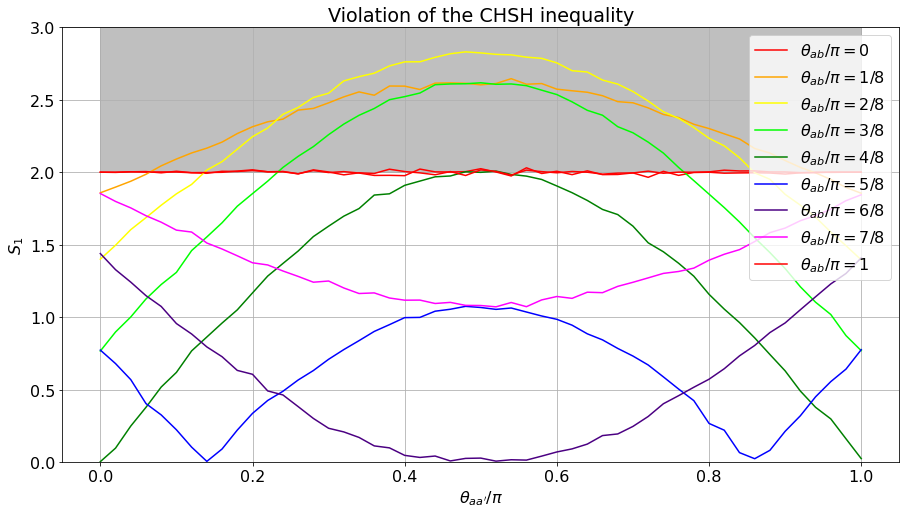

In [44]:
plt.rcParams.update({'font.size': 16})
colors = ["red", "orange", "yellow", "lime", "green", "blue", "indigo", "magenta", "red"]
fig, ax = plt.subplots(figsize=(15, 8))
th = [(i/aap_steps) for i in range(aap_steps+1)]
labels=['$\\theta_{ab}/\pi = 0$'] + ['$\\theta_{ab}/\pi = %d/%d$' % (i_ab, ab_steps) for i_ab in range(1, ab_steps)] + ['$\\theta_{ab}/\pi = 1$']

for i_ab in range(ab_steps+1):
    ax.plot(th, CHSH1[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])
    #ax.plot(th, CHSH2[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=2, y2=3, color="0.5", alpha=0.5)
ax.set_ylim([0, 3])
plt.xlabel('$\\theta_{aa\'} / \pi$')
plt.ylabel('$S_1$')
plt.title('Violation of the CHSH inequality')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
#fig.savefig("simulation_CHSH_Qibo.pdf")

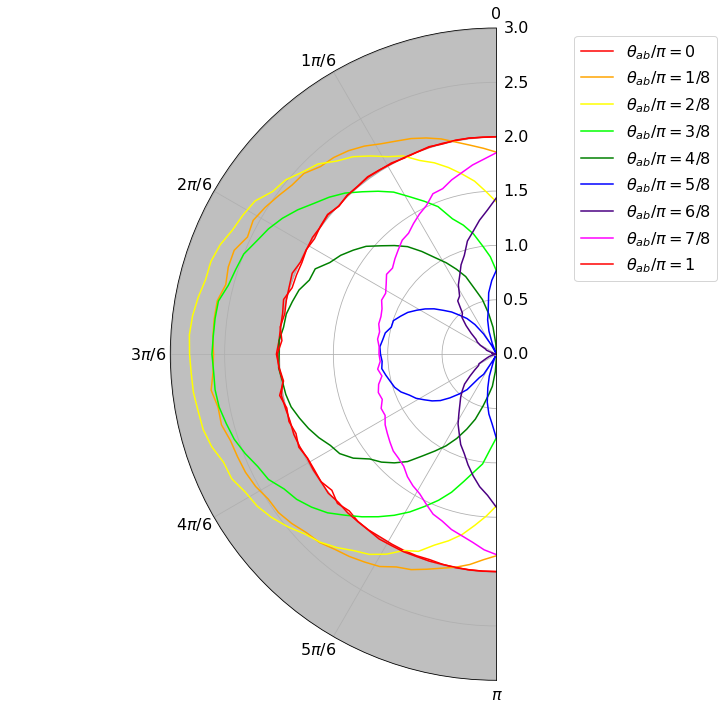

In [43]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
th = [(i*pi/aap_steps) for i in range(aap_steps+1)]

for i_ab in range(ab_steps+1):
    ax.plot(th, CHSH1[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=2, y2=3, color="0.5", alpha=0.5)

ax.set_xticks([(i*pi/6) for i in range(7)], labels=['0'] + ['$%d\\pi/6$    ' % i for i in range(1, 6)] + ['$\\pi$'])
ax.set_theta_zero_location("N")
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim([0, 3])

#plt.title('Violation of the CHSH inequality')
plt.grid(True)
ax.legend(bbox_to_anchor=(1.1, 1.0))
plt.show()
#fig.savefig("simulation_CHSH_Qibo_polar.pdf")